In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Treino + ranking de CVAE para modelagem de canal VLC
====================================================

• Autor:  <Rodrigo Fuchs Miranda>
• Data :  09/06/2025>
"""

# ────────────────────────────────────────────────────────────────────────
# 0)  IMPORTS & BACKEND
# ────────────────────────────────────────────────────────────────────────
import os
import time
import itertools
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats
import matplotlib.pyplot as plt

# GPU/CPU backend setup
try:
    import cupy as cp
    xp, gpu_enabled = cp, True
    print("CuPy (GPU) backend ativado.")
except ImportError:
    xp, gpu_enabled = np, False
    print("NumPy (CPU) backend ativado.")

# Reproducibilidade
np.random.seed(33)
tf.random.set_seed(33)
# if gpu_enabled:
#     cp.random.seed(33)

# ────────────────────────────────────────────────────────────────────────
# 1)  CARREGAMENTO E PREPARAÇÃO DOS DADOS (multi-distância)
# ────────────────────────────────────────────────────────────────────────
print("Carregando dados com distâncias…")
datasets = {
    0.5: r"/content/drive/MyDrive/Temp/FULLSQUARE/0,5metros/IQ_data",
    1.0: r"/content/drive/MyDrive/Temp/FULLSQUARE/1metro/IQ_data",
    1.5: r"/content/drive/MyDrive/Temp/FULLSQUARE/1,5metros/IQ_data",
}

X_list, Y_list, D_list = [], [], []
for dist, folder in datasets.items():
    X_list.append(np.load(os.path.join(folder,"sent_data_tuple.npy")))
    Y_list.append(np.load(os.path.join(folder,"received_data_tuple_sync-phase.npy")))
    D_list.append( np.full((X_list[-1].shape[0],1), dist, dtype=np.float32) )

X = np.concatenate(X_list)          # (N,2)
Y = np.concatenate(Y_list)          # (N,2)
D = np.concatenate(D_list)          # (N,1)

D = (D - 0.5) / (1.5 - 0.5)   # escala para 0-1


idx = np.arange(len(X))
np.random.shuffle(idx)
X, Y, D = X[idx], Y[idx], D[idx]
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
D_train, D_test = D[:split], D[split:]
# ────────────────────────────────────────────────────────────────────────
# 2)  FUNÇÕES DE MÉTRICA
# ────────────────────────────────────────────────────────────────────────

def safe_log10(x, eps=1e-12):
    """Log10 seguro com epsilon para evitar log(0)"""
    return xp.log10(xp.maximum(x, eps))

def safe_log2(x, eps=1e-12):
    """Log2 seguro com epsilon para evitar log(0)"""
    return xp.log2(xp.maximum(x, eps))

def calculate_evm(ref, test):
    """Calcula EVM (Error Vector Magnitude)"""
    ref, test = xp.asarray(ref), xp.asarray(test)
    rc = ref[:,0] + 1j * ref[:,1]
    tc = test[:,0] + 1j * test[:,1]

    mean_power = xp.mean(xp.abs(rc)**2)
    if mean_power == 0:
        return float('inf'), float('-inf')

    err = tc - rc
    evm_val = xp.sqrt(xp.mean(xp.abs(err)**2) / mean_power)
    evm_pct = float(evm_val * 100)
    evm_db = float(20 * safe_log10(evm_val))

    return evm_pct, evm_db

def calculate_snr(ref, test):
    """Calcula SNR (Signal-to-Noise Ratio)"""
    ref, test = xp.asarray(ref), xp.asarray(test)
    rc = ref[:,0] + 1j * ref[:,1]
    tc = test[:,0] + 1j * test[:,1]

    noise = rc - tc
    signal_power = xp.mean(xp.abs(rc)**2)
    noise_power = xp.mean(xp.abs(noise)**2)

    if noise_power == 0:
        return float('inf') if signal_power > 0 else 0.0

    snr_val = signal_power / noise_power
    return float(10 * safe_log10(snr_val))

def calculate_psnr(mse, peak=1.0):
    """Calcula PSNR (Peak Signal-to-Noise Ratio)"""
    if mse <= 0:
        return float('inf') if mse == 0 else float('-inf')
    return float(20 * np.log10(peak) - 10 * np.log10(mse))

def calculate_noise_power(sent, recv):
    """Calcula potência do ruído"""
    sent, recv = xp.asarray(sent), xp.asarray(recv)
    noise = recv - sent
    return float(xp.mean(xp.sum(noise**2, axis=1)))

def compute_basic_metrics(x, y):
    """Calcula métricas básicas (MSE, RMSE, MAE, correlação)"""
    x_gpu, y_gpu = xp.asarray(x), xp.asarray(y)
    err = x_gpu - y_gpu

    # MSE e RMSE
    mse = float(xp.mean(xp.sum(err**2, axis=1)))
    rmse = float(xp.sqrt(mse))

    # MAE
    mae = float(xp.mean(xp.linalg.norm(err, axis=1)))

    # Similaridade cosseno
    norm_x = xp.linalg.norm(x_gpu.ravel())
    norm_y = xp.linalg.norm(y_gpu.ravel())
    if norm_x == 0 or norm_y == 0:
        cos = 0.0
    else:
        cos = float(xp.dot(x_gpu.ravel(), y_gpu.ravel()) / (norm_x * norm_y))

    # Correlação (na CPU)
    x_cpu = cp.asnumpy(x_gpu) if gpu_enabled else x_gpu
    y_cpu = cp.asnumpy(y_gpu) if gpu_enabled else y_gpu

    if len(x_cpu.ravel()) < 2 or len(y_cpu.ravel()) < 2:
        corr = 0.0
    else:
        try:
            corr_matrix = np.corrcoef(x_cpu.ravel(), y_cpu.ravel())
            corr = float(corr_matrix[0,1]) if corr_matrix.ndim == 2 else 0.0
        except:
            corr = 0.0

    return mse, rmse, mae, cos, corr

# --- KDE-based JSD / KL (GPU-ready) ---
def _kde_gpu(data, positions, bw=0.1, batch_size=3000):
    """Estimação de densidade por kernel na GPU"""
    data = xp.asarray(data)
    val = xp.zeros(positions.shape[0], dtype=xp.float32)
    num_points = len(data)

    if num_points == 0:
        return val

    for i in range(0, num_points, batch_size):
        batch_data = data[i:i+batch_size]
        exp_term = -0.5 * (((batch_data[:,0,None] - positions[:,0])/bw)**2 +
                          ((batch_data[:,1,None] - positions[:,1])/bw)**2)
        val += xp.sum(xp.exp(exp_term), axis=0)

    val /= num_points
    val /= (2 * np.pi * bw**2)  # Normalização Gaussiana

    sum_val = xp.sum(val)
    if sum_val > 0:
        val /= sum_val

    return val

def _prep_grid(grid_res=200, data_min=-1.5, data_max=1.5):
    """Prepara grade para estimação de densidade"""
    xi = xp.linspace(data_min, data_max, grid_res)
    X_grid, Y_grid = xp.meshgrid(xi, xi)
    return xp.stack([X_grid.ravel(), Y_grid.ravel()], axis=1)

def calculate_jsd_gpu(real, pred, grid_res=200, bw=0.1):
    """Calcula Jensen-Shannon Divergence"""
    pos = _prep_grid(grid_res)
    P = _kde_gpu(real, pos, bw)
    Q = _kde_gpu(pred, pos, bw)
    M = 0.5 * (P + Q)

    eps = 1e-12
    jsd = 0.5 * xp.sum(xp.where(P > eps, P * safe_log2(P / (M + eps)), 0)) + \
          0.5 * xp.sum(xp.where(Q > eps, Q * safe_log2(Q / (M + eps)), 0))

    return float(jsd)

def calculate_kl_gpu(real, pred, grid_res=200, bw=0.1):
    """Calcula Kullback-Leibler Divergence"""
    pos = _prep_grid(grid_res)
    P = _kde_gpu(real, pos, bw)
    Q = _kde_gpu(pred, pos, bw)

    eps = 1e-12
    kl_val = xp.sum(xp.where(P > eps, P * xp.log((P + eps) / (Q + eps)), 0))

    return float(kl_val)

def calculate_ks_test(data1, data2):
    """Calcula teste Kolmogorov-Smirnov"""
    if gpu_enabled:
        data1 = cp.asnumpy(data1) if isinstance(data1, cp.ndarray) else data1
        data2 = cp.asnumpy(data2) if isinstance(data2, cp.ndarray) else data2

    if data1.ndim > 1:
        data1 = data1.ravel()
    if data2.ndim > 1:
        data2 = data2.ravel()

    if len(data1) == 0 or len(data2) == 0:
        return 0.0, 0.0

    try:
        ks_statistic, p_value = stats.ks_2samp(data1, data2)
        return float(ks_statistic), float(p_value)
    except:
        return 0.0, 0.0

# ────────────────────────────────────────────────────────────────────────
# 3)  DEFINIÇÕES DO VAE
# ────────────────────────────────────────────────────────────────────────

class Sampling(layers.Layer):
    """Camada de amostragem para VAE"""
    def call(self, inputs):
        z_mu, z_logv = inputs
        eps = tf.random.normal(tf.shape(z_mu))
        return z_mu + tf.exp(0.5 * z_logv) * eps

class BetaScheduler(tf.keras.callbacks.Callback):
    """Agendador de beta para VAE"""
    def __init__(self, loss_layer, max_beta=1.0, warmup_epochs=10):
        super().__init__()
        self.loss_layer = loss_layer
        self.max_beta = max_beta
        self.warmup_epochs = warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if self.warmup_epochs > 0:
            current_beta = self.max_beta * min(1.0, epoch / self.warmup_epochs)
        else:
            current_beta = self.max_beta
        if isinstance(self.loss_layer.beta, tf.Variable):
            self.loss_layer.beta.assign(current_beta)   # ← use assign()
        else:                                           # fallback de segurança
            self.loss_layer.beta = tf.Variable(current_beta, trainable=False)

class VAELossLayer(layers.Layer):
    """
    Enhanced VAE Loss Layer optimized for VLC channel digital twin modeling.

    Combines proper Gaussian NLL with KL divergence and includes robust
    numerical stability measures for telecommunications signal processing.
    """

    def __init__(self, beta=1.0, name="vae_loss_layer", **kwargs):
        super().__init__(name=name, **kwargs)

        # Use tf.Variable for dynamic beta scheduling during training
        self.beta = tf.Variable(beta, trainable=False, dtype=tf.float32, name="beta")

        # Separate metric trackers for monitoring
        self.kl_tracker = tf.keras.metrics.Mean(name="kl_divergence")
        self.nll_tracker = tf.keras.metrics.Mean(name="neg_log_likelihood")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # Additional metrics for VLC channel analysis
        self.reconstruction_error = tf.keras.metrics.Mean(name="reconstruction_error")

    def call(self, inputs):
        x_in, dec_out, y_true, z_mu, z_logv = inputs

        # Separate decoder outputs: mean and log-variance
        mu = dec_out[:, :2]  # First 2 components: I and Q means

        # Clip log-variance for numerical stability (critical for VLC signals)
        logv = tf.clip_by_value(dec_out[:, 2:], -10.0, 10.0)
        var = tf.exp(logv) + 1e-8  # Add small epsilon to prevent division by zero

        # === NEGATIVE LOG-LIKELIHOOD (Gaussian) ===
        # Complete formula for multivariate Gaussian NLL
        diff_squared = tf.square(y_true - mu)

        nll = 0.5 * tf.reduce_mean(
            tf.reduce_sum(
                tf.math.log(2 * np.pi) + logv + (diff_squared / var),
                axis=-1
            )
        )

        # === KL DIVERGENCE ===
        # KL divergence between learned latent distribution and standard Gaussian
        kl_div = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_logv - tf.square(z_mu) - tf.exp(z_logv),
                axis=-1
            )
        )

        # === TOTAL LOSS ===
        total_loss = nll + self.beta * kl_div

        # Add loss to the model
        self.add_loss(total_loss)

        # === UPDATE METRICS ===
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl_div)
        self.total_loss_tracker.update_state(total_loss)

        # Track reconstruction error for VLC channel analysis
        mse = tf.reduce_mean(diff_squared)
        self.reconstruction_error.update_state(mse)

        # === REPARAMETERIZATION TRICK ===
        # Sample from learned distribution
        eps = tf.random.normal(tf.shape(mu))
        sampled_output = mu + tf.sqrt(var) * eps

        return sampled_output

    @property
    def metrics(self):
        """Return all tracked metrics"""
        return [
            self.nll_tracker,
            self.kl_tracker,
            self.total_loss_tracker,
            self.reconstruction_error
        ]

    def get_kl(self):
        """Get current KL divergence value - useful for monitoring training"""
        return self.kl_tracker.result().numpy()

    def get_nll(self):
        """Get current NLL value - useful for monitoring reconstruction quality"""
        return self.nll_tracker.result().numpy()

    def get_reconstruction_error(self):
        """Get current reconstruction MSE - important for VLC channel fidelity"""
        return self.reconstruction_error.result().numpy()

    def update_beta(self, new_beta):
        """Update beta value during training (for beta-VAE scheduling)"""
        self.beta.assign(new_beta)

    def get_config(self):
        config = super().get_config()
        beta_val = self.beta.numpy() if isinstance(self.beta, tf.Variable) else self.beta
        config.update({"beta": float(beta_val)})
        return config

    @classmethod
    def from_config(cls, config):
        """Enable model loading"""
        return cls(**config)

# ----------------------------------------------------------------------
# 3-A)  ENCODER CONDICIONAL
# ----------------------------------------------------------------------
def build_encoder(layer_sizes, latent_dim, activation='leaky_relu'):
    """
    Encoder condicional: recebe (x_in, d_in, y_in)  →  (z_mu, z_logv)
    layer_sizes : lista, ex. [128, 256, 512]
    latent_dim  : dimensão do espaço latente (int)
    """
    x_in = layers.Input(shape=(2,), name="encoder_x_input")   # I/Q enviado
    d_in = layers.Input(shape=(1,), name="encoder_d_input")   # distância normalizada
    y_in = layers.Input(shape=(2,), name="encoder_y_input")   # I/Q recebido

    h = layers.Concatenate()([x_in, d_in, y_in])              # 2 + 1 + 2 = 5
    for size in reversed(layer_sizes):
        h = layers.Dense(size, activation=activation)(h)

    z_mu    = layers.Dense(latent_dim, name="z_mu")(h)
    z_logv  = layers.Dense(latent_dim, name="z_log_var")(h)

    return models.Model([x_in, d_in, y_in], [z_mu, z_logv],
                        name="conditional_encoder")


# ----------------------------------------------------------------------
# 3-B)  DECODER CONDICIONAL
# ----------------------------------------------------------------------
def build_decoder(layer_sizes, latent_dim, activation='leaky_relu'):
    """
    Decoder condicional: recebe (z, [x_in, d_in])  →  parâmetros (μ_I, μ_Q, logσ²_I, logσ²_Q)
    """
    z_in         = layers.Input(shape=(latent_dim,), name="decoder_z_input")
    condition_in = layers.Input(shape=(3,), name="decoder_condition_input")  # 2 + 1

    h = layers.Concatenate()([z_in, condition_in])
    for size in layer_sizes:
        h = layers.Dense(size, activation=activation)(h)

    out = layers.Dense(4, activation="linear", name="mu_logv")(h)

    return models.Model([z_in, condition_in], out, name="conditional_decoder")


def build_conditional_vae(layer_sizes, latent_dim, activation, beta, learning_rate):
    """
    Constrói o CVAE completo (encoder e decoder condicionados por distância).
    """
    # 1. Instancia encoder e decoder já corrigidos
    enc = build_encoder(layer_sizes, latent_dim, activation)
    dec = build_decoder(layer_sizes, latent_dim, activation)

    # 2. Entradas externas do modelo
    x_in   = layers.Input(shape=(2,), name="x_in")          # I/Q transmitido
    d_in   = layers.Input(shape=(1,), name="d_in")          # distância normalizada
    y_true = layers.Input(shape=(2,), name="y_true")        # I/Q recebido (alvo)

    # 3. Passa (x, d, y) pelo encoder  →  z
    z_mu, z_logv = enc([x_in, d_in, y_true])
    z = Sampling()([z_mu, z_logv])                          # amostragem reparametrizada

    # 4. Concatena condição para o decoder: (x, d)  →  shape (3,)
    cond_vec = layers.Concatenate(name="decoder_condition")([x_in, d_in])

    # 5. Gera a predição
    y_pred = dec([z, cond_vec])

    # 6. Calcula a perda VAE (reconstrução + β·KL)
    loss_layer = VAELossLayer(beta=beta, name="vae_loss")
    y_out = loss_layer([x_in, y_pred, y_true, z_mu, z_logv])

    # 7. Modelo final
    vae = models.Model(inputs=[x_in, d_in, y_true],
                       outputs=y_out,
                       name="conditional_vae")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=None)

    # 8. Scheduler opcional para aquecer o β
    beta_scheduler = BetaScheduler(loss_layer,
                                   max_beta=beta,
                                   warmup_epochs=10)

    return vae, beta_scheduler


# ────────────────────────────────────────────────────────────────────────
# 4)  CONFIGURAÇÃO DO GRID SEARCH
# ────────────────────────────────────────────────────────────────────────

param_grid = {
    "layer1": [128],
    "layer2": [256],
    "layer3": [512],
    "latent_dim": [48],
    "beta": [0.48],
    "batch_size": [20000],
    "learning_rate": [1e-4],
    "activation": ["leaky_relu"]
}

# Configuração de logs
logs_base_dir = "/content/drive/MyDrive/Temp/IQ_data/logs_runs/"


os.makedirs(logs_base_dir, exist_ok=True)

log_path = os.path.join(logs_base_dir, "experimentos.csv")
ranked_log_path = os.path.join(logs_base_dir, "experimentos_ranked.csv")

# Limpar logs existentes
for path in [log_path, ranked_log_path]:
    if os.path.exists(path):
        print(f"Removendo arquivo existente: {path}")
        os.remove(path)

# ────────────────────────────────────────────────────────────────────────
# 5)  EXECUÇÃO DO GRID SEARCH
# ────────────────────────────────────────────────────────────────────────

print("\nIniciando Grid Search...")
results_list = []
total_combos = len(list(itertools.product(*param_grid.values())))

for i, combo in enumerate(itertools.product(*param_grid.values())):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\n--- Combinação {i+1}/{total_combos} ---")
    print(params)

    # Construir modelo
    layer_sizes = [params['layer1'], params['layer2'], params['layer3']]
    vae, beta_scheduler = build_conditional_vae(
        layer_sizes=layer_sizes,
        latent_dim=params['latent_dim'],
        activation=params['activation'],
        beta=params['beta'],
        learning_rate=params['learning_rate']
    )

    # Callback de early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    # Treinamento
    start_time = time.time()
    history = vae.fit(
        [X_train, D_train, Y_train], Y_train,
        validation_data=([X_test, D_test, Y_test], Y_test),
        epochs=800,
        batch_size=params['batch_size'],
        callbacks=[early_stopping, beta_scheduler],
        verbose=0
    )
    duration = time.time() - start_time


    # Extrair métricas do treinamento
    val_losses = history.history.get('val_loss', [])
    best_val_loss = min(val_losses) if val_losses else float('inf')
    epochs_trained = len(history.history['loss'])

    # Predições
    Y_pred = vae.predict([X_test, D_test, Y_test],

                        batch_size=params['batch_size'],
                        verbose=0)
    Y_pred = Y_pred[:len(Y_test)]  # Garantir mesmo tamanho

    # Calcular métricas
    try:
        # Métricas básicas
        evm_real_pct, _ = calculate_evm(X_test, Y_test)
        evm_pred_pct, _ = calculate_evm(X_test, Y_pred)
        snr_real = calculate_snr(X_test, Y_test)
        snr_pred = calculate_snr(X_test, Y_pred)
        noise_pow_real = calculate_noise_power(X_test, Y_test)
        noise_pow_pred = calculate_noise_power(X_test, Y_pred)

        # Métricas de distribuição
        kl_divergence = calculate_kl_gpu(Y_test, Y_pred)
        jsd = calculate_jsd_gpu(Y_test, Y_pred)

        # Testes KS
        ks_stat_i, p_val_i = calculate_ks_test(Y_test[:, 0], Y_pred[:, 0])
        ks_stat_q, p_val_q = calculate_ks_test(Y_test[:, 1], Y_pred[:, 1])

        # Métricas básicas
        mse, rmse, mae, cos_sim, corr = compute_basic_metrics(X_test, Y_pred)
        psnr = calculate_psnr(mse)

        # KL latente
        kl_latent = 0.0
        for layer in vae.layers:
            if isinstance(layer, VAELossLayer):
                kl_latent = layer.get_kl()
                break

    except Exception as e:
        print(f"Erro no cálculo de métricas: {e}")
        # Valores padrão em caso de erro
        evm_real_pct = evm_pred_pct = float('inf')
        snr_real = snr_pred = 0.0
        noise_pow_real = noise_pow_pred = 0.0
        kl_divergence = jsd = float('inf')
        ks_stat_i = ks_stat_q = p_val_i = p_val_q = 0.0
        mse = rmse = mae = psnr = float('inf')
        cos_sim = corr = kl_latent = 0.0

    # Registro dos resultados
    result = {
        **params,
        "val_loss": best_val_loss,
        "kl_latent": kl_latent,
        "kl_real_pred": kl_divergence,
        "jsd_real_pred": jsd,
        "ks_stat_i": ks_stat_i,
        "p_value_i": p_val_i,
        "ks_stat_q": ks_stat_q,
        "p_value_q": p_val_q,
        "evm_real_%": evm_real_pct,
        "evm_pred_%": evm_pred_pct,
        "delta_evm_%": evm_pred_pct - evm_real_pct,
        "snr_real_dB": snr_real,
        "snr_pred_dB": snr_pred,
        "delta_snr_dB": snr_pred - snr_real,
        "rmse_pred": rmse,
        "psnr_pred_dB": psnr,
        "diff_noise_pow": noise_pow_pred - noise_pow_real,
        "epochs": epochs_trained,
        "duration_sec": round(duration, 2),
        "timestamp": datetime.datetime.now().isoformat(timespec='seconds')
    }

    results_list.append(result)

    print(f" → val_loss={result['val_loss']:.4f} | "
          f"ΔEVM={result['delta_evm_%']:+.2f}% | "
          f"ΔSNR={result['delta_snr_dB']:+.2f} dB | "
          f"JSD={result['jsd_real_pred']:.4f}")

# Salvar resultados
df_results = pd.DataFrame(results_list)
df_results.to_csv(log_path, index=False)
print(f"\nResultados salvos em: {log_path}")

# ────────────────────────────────────────────────────────────────────────
# 6)  RANKING DOS MODELOS
# ────────────────────────────────────────────────────────────────────────

print("\nIniciando ranking dos modelos...")

# Critérios de ranking e pesos
ranking_criteria = {
    'delta_evm_%': {'weight': -1.0, 'maximize': False},
    'delta_snr_dB': {'weight': 1.0, 'maximize': True},
    'jsd_real_pred': {'weight': -2.0, 'maximize': False},
    'rmse_pred': {'weight': -1.0, 'maximize': False},
    'diff_noise_pow': {'weight': -0.5, 'maximize': False},
    'p_value_i': {'weight': 1.0, 'maximize': True},
    'p_value_q': {'weight': 1.0, 'maximize': True}
}

# Normalização robusta das métricas
df_normalized = df_results.copy()
df_normalized['score'] = 0.0

for metric, props in ranking_criteria.items():
    if metric in df_results.columns:
        values = df_results[metric]

        # Verificar se há variação nos dados
        if values.nunique() <= 1 or not np.isfinite(values).all():
            print(f"Aviso: Métrica '{metric}' tem valores constantes ou inválidos")
            df_normalized[f'{metric}_norm'] = 0.0
            continue

        # Normalização robusta (usando mediana e IQR)
        median = values.median()
        q25, q75 = values.quantile([0.25, 0.75])
        iqr = q75 - q25

        if iqr == 0:
            print(f"Aviso: IQR zero para métrica '{metric}'")
            df_normalized[f'{metric}_norm'] = 0.0
            continue

        # Normalizar
        normalized = (values - median) / iqr
        df_normalized[f'{metric}_norm'] = normalized

        # Calcular contribuição para o score
        if props['maximize']:
            score_contrib = normalized * props['weight']
        else:
            score_contrib = -normalized * props['weight']

        df_normalized['score'] += score_contrib

# Ranking final
df_ranked = df_normalized.sort_values('score', ascending=False)
df_ranked.to_csv(ranked_log_path, index=False, sep=';', decimal=',')
print(f"Resultados rankeados salvos em: {ranked_log_path}")


# Mostrar top modelos
TOP_N = 10
display_cols = ['score'] + list(param_grid.keys()) + list(ranking_criteria.keys())
display_cols = [col for col in display_cols if col in df_ranked.columns]

print(f"\n### TOP-{TOP_N} MODELOS ###")
print(df_ranked[display_cols].head(TOP_N).to_string(index=False))

# Selecionar melhor modelo
best_model = df_ranked.iloc[0]
print(f"\nMelhor modelo selecionado com score: {best_model['score']:.4f}")

print("\n🏆 GRID SEARCH CONCLUÍDO! 🏆")
print(f"Total de combinações testadas: {total_combos}")
print(f"Melhor configuração encontrada:")
for param in param_grid.keys():
    if param in best_model.index:
        print(f"  {param}: {best_model[param]}")

CuPy (GPU) backend ativado.
Carregando dados com distâncias…
Removendo arquivo existente: /content/drive/MyDrive/Temp/IQ_data/logs_runs/experimentos.csv
Removendo arquivo existente: /content/drive/MyDrive/Temp/IQ_data/logs_runs/experimentos_ranked.csv

Iniciando Grid Search...

--- Combinação 1/1 ---
{'layer1': 128, 'layer2': 256, 'layer3': 512, 'latent_dim': 48, 'beta': 0.48, 'batch_size': 20000, 'learning_rate': 0.0001, 'activation': 'leaky_relu'}
Epoch 503: early stopping
Restoring model weights from the end of the best epoch: 483.
Erro no cálculo de métricas: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version
 → val_loss=-4.7363 | ΔEVM=+nan% | ΔSNR=+0.00 dB | JSD=inf

Resultados salvos em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/experimentos.csv

Iniciando ranking dos modelos...
Aviso: Métrica 'delta_evm_%' tem valores constantes ou inválidos
Aviso: Métrica 'delta_snr_dB' tem valores constantes ou inválidos
Aviso: Métrica 'jsd_real_pred'


Retreinando o modelo campeão...
Retreinando por 503 épocas com batch_size 20000
Epoch 1/503
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 268ms/step - kl_divergence: 1.5357 - loss: 1.3385 - neg_log_likelihood: 1.3385 - reconstruction_error: 0.2359 - total_loss: 1.3385
Epoch 2/503
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - kl_divergence: 18.4213 - loss: -0.3834 - neg_log_likelihood: -1.2677 - reconstruction_error: 0.0145 - total_loss: -0.3834
Epoch 3/503
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 269ms/step - kl_divergence: 15.8866 - loss: -0.8063 - neg_log_likelihood: -2.3314 - reconstruction_error: 0.0052 - total_loss: -0.8063
Epoch 4/503
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - kl_divergence: 10.1930 - loss: -1.2722 - neg_log_likelihood: -2.7400 - reconstruction_error: 0.0033 - total_loss: -1.2722
Epoch 5/503
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - kl_divergence: 7.9284 - loss: -1.4138 - neg_log_likelihood: -2.9361 - reconstruction_error: 0.0027 - total_loss: -1.4138
Epoch 6/503
108/108 ━━━━

<ipython-input-5-1014692270>:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Plot de constelações salvo em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/campeao_constelacao_plot.png


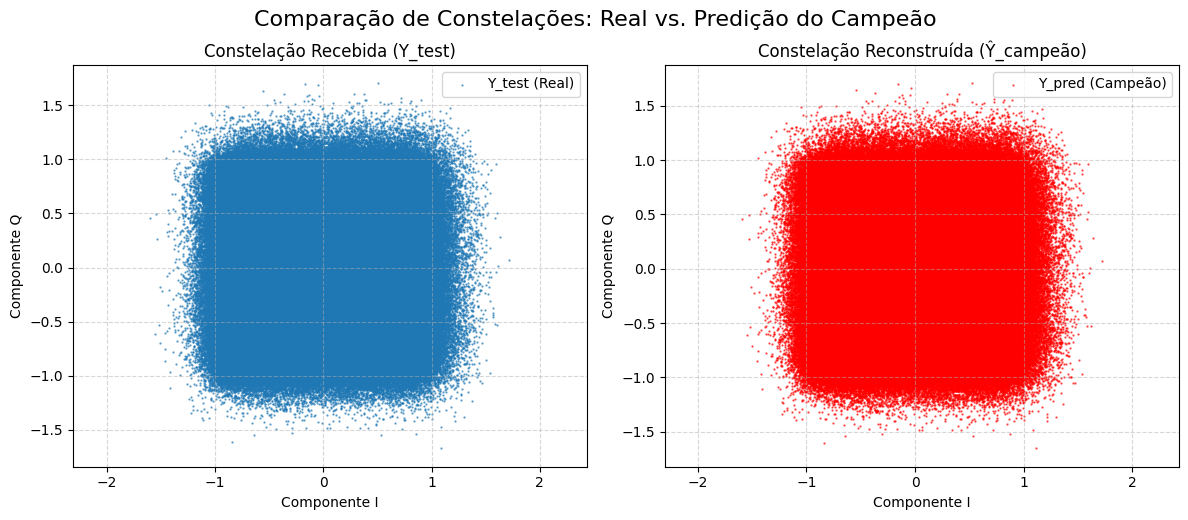

Plot de histogramas de ruído salvo em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/campeao_histogramas_ruido_plot.png


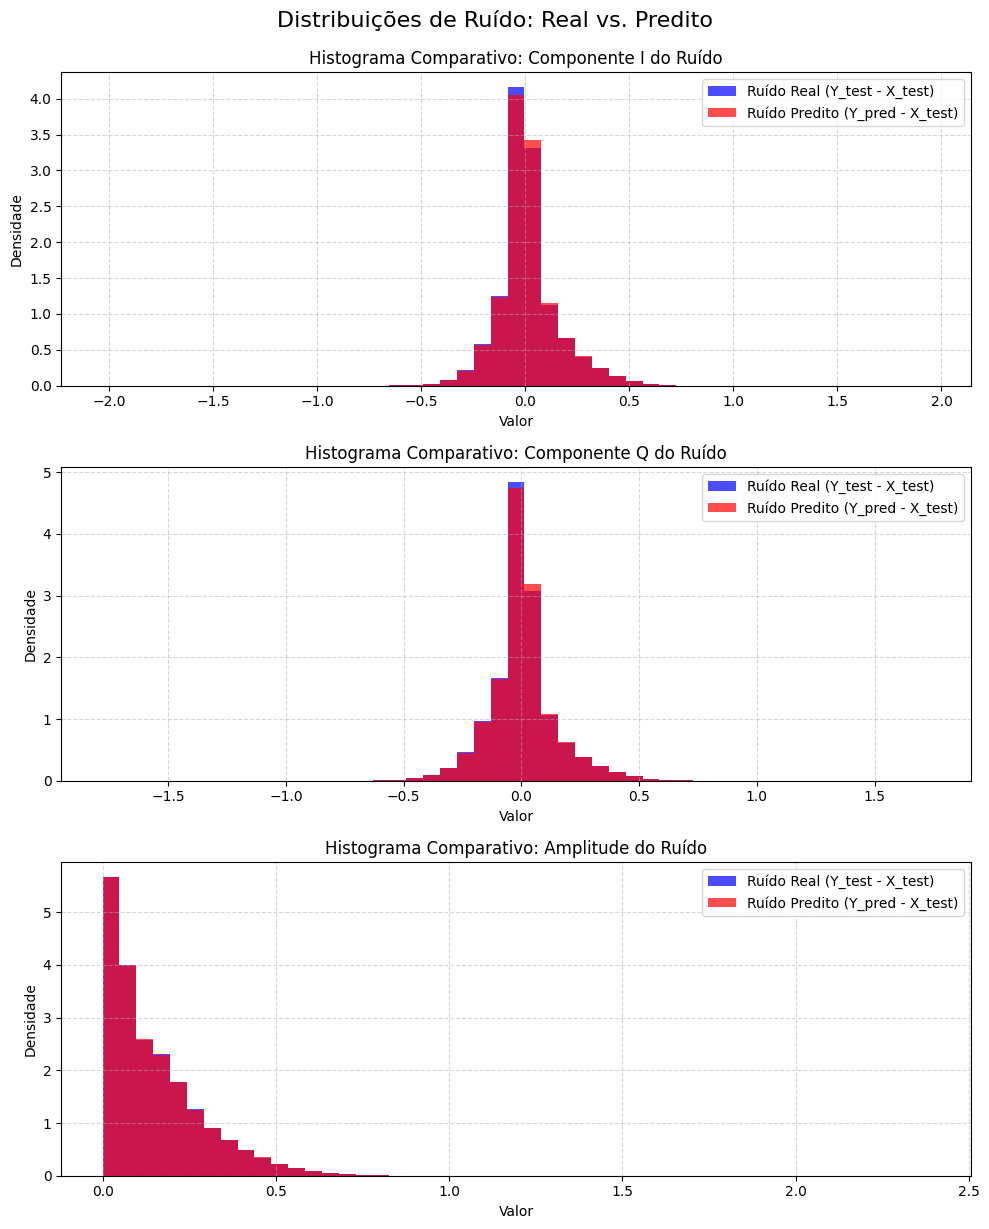

Plot Q-Q salvo em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/campeao_qq_plot.png


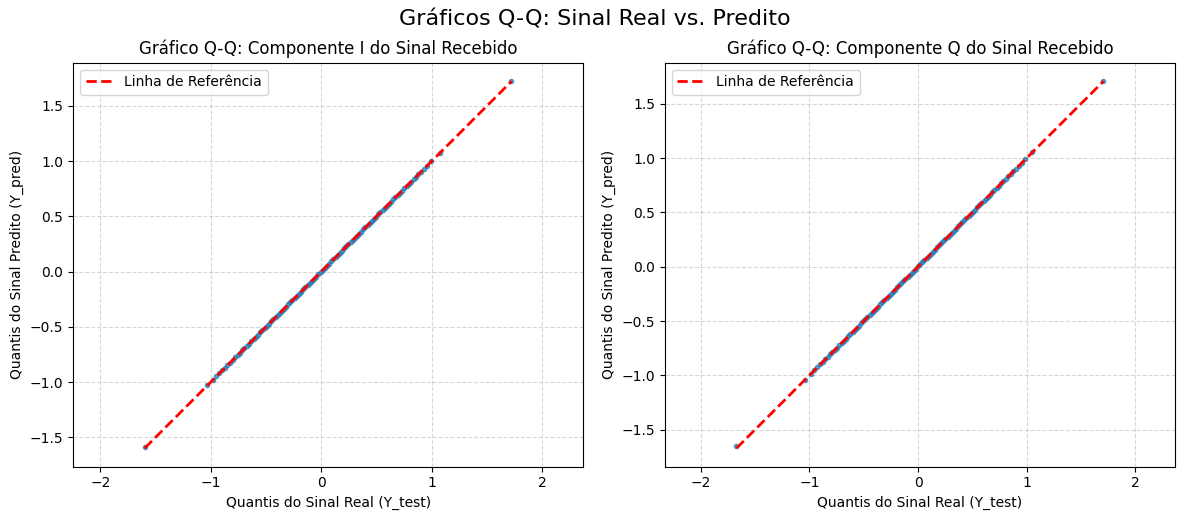

Plot da curva de transferência salvo em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/campeao_curva_transferencia_plot.png


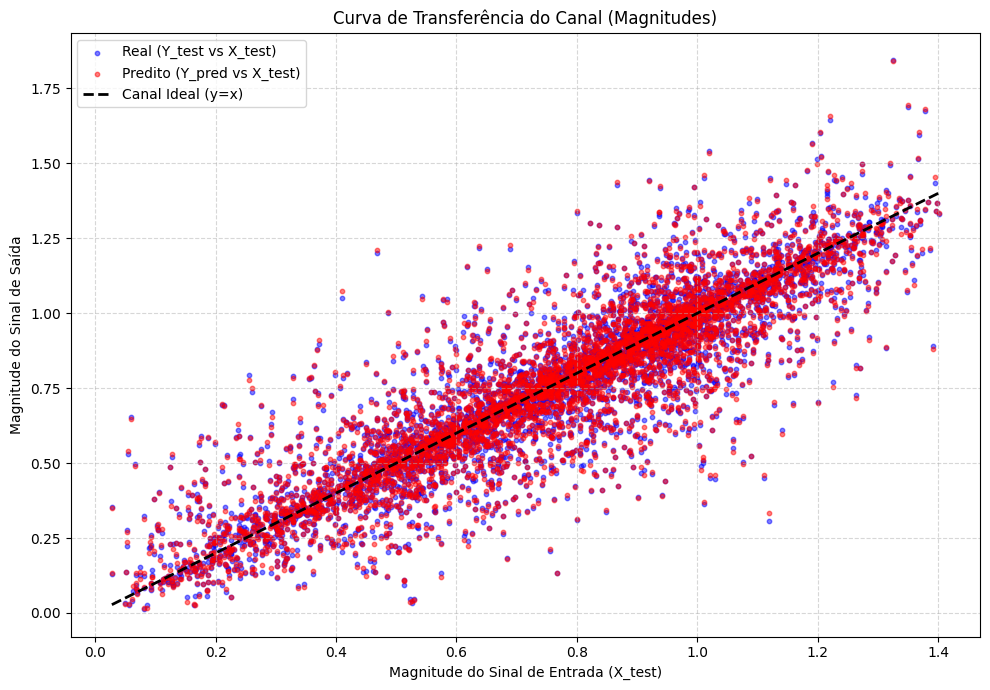

Plot do mapa de vetores de erro salvo em: /content/drive/MyDrive/Temp/IQ_data/logs_runs/campeao_mapa_vetores_erro_plot.png


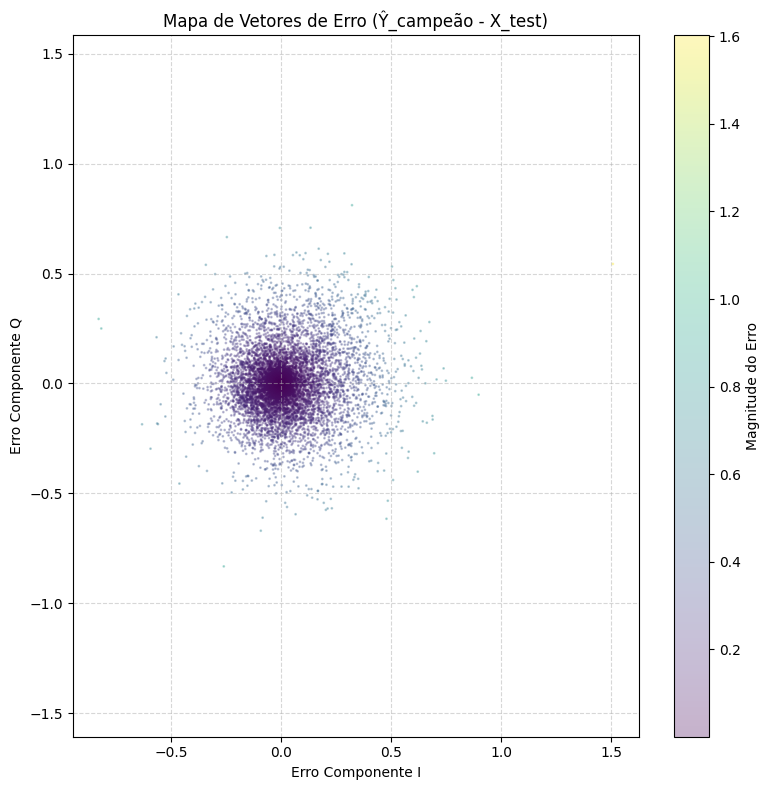


🏆  MÉTRICAS DO MODELO CAMPEÃO  🏆
Hiperparâmetros:
  layer1: 128
  layer2: 256
  layer3: 512
  latent_dim: 48
  beta: 0.48
  batch_size: 20000
  learning_rate: 0.0001
  activation: leaky_relu


CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# ────────────────────────────────────────────────────────────────────────
# 7)  RETREINA E SALVA O MODELO CAMPEÃO
# ────────────────────────────────────────────────────────────────────────
print("\nRetreinando o modelo campeão...")

# Selecionar os parâmetros do melhor modelo
best_params = {k: best_model[k] for k in param_grid.keys() if k in best_model.index}

# Construir o modelo campeão
vae_best, beta_cb_champion = build_conditional_vae(
    layer_sizes=[int(best_params['layer1']), int(best_params['layer2']), int(best_params['layer3'])],
    latent_dim=int(best_params['latent_dim']),
    activation=best_params['activation'],
    beta=float(best_params['beta']),
    learning_rate=float(best_params['learning_rate'])
)

# Configurar treinamento do campeão
epochs_champion_retrain = int(best_model['epochs'])
batch_size_champion_retrain = int(best_params['batch_size'])

print(f"Retreinando por {epochs_champion_retrain} épocas com batch_size {batch_size_champion_retrain}")

# Treinar o modelo campeão
history_champion = vae_best.fit(
    [X_train, D_train, Y_train], Y_train,
    epochs=epochs_champion_retrain,
    batch_size=batch_size_champion_retrain,
    callbacks=[beta_cb_champion],
    verbose=1
)

# Gerar predições finais
Y_pred_final_champion = vae_best.predict(
    [X_test, D_test, Y_test],
    batch_size=batch_size_champion_retrain,
    verbose=0
)
Y_pred_final_champion = Y_pred_final_champion[:Y_test.shape[0]]

# ─── Salvar o modelo campeão em dois formatos (CORRIGIDO para Colab / Keras 3) ───

# Nomes e caminhos para os modelos
modelo_escolhido = "cvae_campeao"
logs_base_dir = "/content/drive/MyDrive/Temp/IQ_data/logs_runs" # Exemplo de caminho

savedmodel_dir= os.path.join(logs_base_dir, modelo_escolhido + "_exported") # Pasta para SavedModel
keras_file= os.path.join(logs_base_dir, modelo_escolhido + ".keras")# Arquivo .keras



print(f"Exportando modelo para produção (TF-Serving) em: {savedmodel_dir}")
# 1) SavedModel (pasta) → Use .export() para criar um modelo para inferência.
#    Este é o método correto e moderno para compatibilidade com TF-Serving.
vae_best.export(savedmodel_dir)

print(f"Salvando modelo em formato nativo Keras em: {keras_file}")
# 2) Arquivo único .keras → Seu código já estava correto para esta parte!
#    .save() é o método certo para salvar em um arquivo .keras.
vae_best.save(keras_file, include_optimizer=False)

print("\nModelos salvos com sucesso nos dois formatos!")
print("✅ Modelo campeão salvo em:")
print(f"   • {savedmodel_dir}   (SavedModel)")
print(f"   • {keras_file} (.keras)")

#  salvar o decoder como artefacto de produção3c
decoder_path = os.path.join(logs_base_dir, "cvae_decoder.keras")
decoder = vae_best.get_layer("conditional_decoder")
decoder.save(decoder_path, include_optimizer=False)
print("Decoder salvo em:", decoder_path)

# ────────────────────────────────────────────────────────────────────────
# 8)  PLOTS E MÉTRICAS DO CAMPEÃO
# ────────────────────────────────────────────────────────────────────────
print("\nGerando análises visuais e métricas para o modelo campeão...")

# Converter dados para CPU para plotagem
if gpu_enabled:
    y_test_cpu = cp.asnumpy(Y_test) if isinstance(Y_test, cp.ndarray) else Y_test
    y_pred_final_champion_cpu = cp.asnumpy(Y_pred_final_champion) if isinstance(Y_pred_final_champion, cp.ndarray) else Y_pred_final_champion
    x_test_cpu = cp.asnumpy(X_test) if isinstance(X_test, cp.ndarray) else X_test
else:
    y_test_cpu = Y_test
    y_pred_final_champion_cpu = Y_pred_final_champion
    x_test_cpu = X_test

# --- 8.1 Constelações ---
fig_const, ax_const = plt.subplots(1, 2, figsize=(12, 5))

ax_const[0].scatter(y_test_cpu[:,0], y_test_cpu[:,1], s=0.5, alpha=0.6, label="Y_test (Real)")
ax_const[0].set_title("Constelação Recebida (Y_test)")
ax_const[0].set_xlabel("Componente I")
ax_const[0].set_ylabel("Componente Q")
ax_const[0].axis('equal')
ax_const[0].grid(True, linestyle='--', alpha=0.5)
ax_const[0].legend()

ax_const[1].scatter(y_pred_final_champion_cpu[:,0], y_pred_final_champion_cpu[:,1], s=0.5, alpha=0.6, color='red', label="Y_pred (Campeão)")
ax_const[1].set_title("Constelação Reconstruída (Ŷ_campeão)")
ax_const[1].set_xlabel("Componente I")
ax_const[1].set_ylabel("Componente Q")
ax_const[1].axis('equal')
ax_const[1].grid(True, linestyle='--', alpha=0.5)
ax_const[1].legend()

plt.tight_layout()
plt.suptitle("Comparação de Constelações: Real vs. Predição do Campeão", fontsize=16, y=1.03)
plot_save_path_const = os.path.join(logs_base_dir, "campeao_constelacao_plot.png")
plt.savefig(plot_save_path_const, dpi=300, bbox_inches='tight')
print(f"Plot de constelações salvo em: {plot_save_path_const}")
plt.show()

# --- 8.2 Análise de Distribuições de Ruído ---
noise_real = y_test_cpu - x_test_cpu
noise_pred = y_pred_final_champion_cpu - x_test_cpu

noise_real_I = noise_real[:,0]
noise_real_Q = noise_real[:,1]
noise_real_Amp = np.sqrt(noise_real_I**2 + noise_real_Q**2)

noise_pred_I = noise_pred[:,0]
noise_pred_Q = noise_pred[:,1]
noise_pred_Amp = np.sqrt(noise_pred_I**2 + noise_pred_Q**2)

data_to_plot_noise = [
    (noise_real_I, noise_pred_I, 'Componente I do Ruído'),
    (noise_real_Q, noise_pred_Q, 'Componente Q do Ruído'),
    (noise_real_Amp, noise_pred_Amp, 'Amplitude do Ruído')
]

fig_hist_noise, axes_hist_noise = plt.subplots(len(data_to_plot_noise), 1, figsize=(10, 4 * len(data_to_plot_noise)))
if len(data_to_plot_noise) == 1:
    axes_hist_noise = [axes_hist_noise]

for i, (data_r, data_p, title_suffix) in enumerate(data_to_plot_noise):
    min_val = min(np.min(data_r), np.min(data_p))
    max_val = max(np.max(data_r), np.max(data_p))
    bins = np.linspace(min_val, max_val, 50)

    axes_hist_noise[i].hist(data_r, bins=bins, alpha=0.7, label='Ruído Real (Y_test - X_test)', color='blue', density=True)
    axes_hist_noise[i].hist(data_p, bins=bins, alpha=0.7, label='Ruído Predito (Y_pred - X_test)', color='red', density=True)
    axes_hist_noise[i].set_title(f'Histograma Comparativo: {title_suffix}')
    axes_hist_noise[i].set_xlabel('Valor')
    axes_hist_noise[i].set_ylabel('Densidade')
    axes_hist_noise[i].legend()
    axes_hist_noise[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Distribuições de Ruído: Real vs. Predito", fontsize=16, y=1.02)
plot_save_path_hist_noise = os.path.join(logs_base_dir, "campeao_histogramas_ruido_plot.png")
plt.savefig(plot_save_path_hist_noise, dpi=300, bbox_inches='tight')
print(f"Plot de histogramas de ruído salvo em: {plot_save_path_hist_noise}")
plt.show()

# --- 8.3 Gráficos Q-Q (Quantil-Quantil) ---
data_to_qq_signal = [
    (y_test_cpu[:,0], y_pred_final_champion_cpu[:,0], 'Componente I do Sinal Recebido'),
    (y_test_cpu[:,1], y_pred_final_champion_cpu[:,1], 'Componente Q do Sinal Recebido'),
]

fig_qq, axes_qq = plt.subplots(1, len(data_to_qq_signal), figsize=(6 * len(data_to_qq_signal), 5))
if len(data_to_qq_signal) == 1:
    axes_qq = [axes_qq]

for i, (data_r, data_p, title_suffix) in enumerate(data_to_qq_signal):
    quantiles = np.linspace(0, 100, 101)
    qn_r = np.percentile(data_r, quantiles)
    qn_p = np.percentile(data_p, quantiles)

    axes_qq[i].plot(qn_r, qn_p, 'o', markersize=3, alpha=0.7)
    min_val_qq = min(np.min(qn_r), np.min(qn_p))
    max_val_qq = max(np.max(qn_r), np.max(qn_p))
    axes_qq[i].plot([min_val_qq, max_val_qq], [min_val_qq, max_val_qq], 'r--', lw=2, label='Linha de Referência')
    axes_qq[i].set_xlabel('Quantis do Sinal Real (Y_test)')
    axes_qq[i].set_ylabel('Quantis do Sinal Predito (Y_pred)')
    axes_qq[i].set_title(f'Gráfico Q-Q: {title_suffix}')
    axes_qq[i].axis('equal')
    axes_qq[i].grid(True, linestyle='--', alpha=0.5)
    axes_qq[i].legend()

plt.tight_layout()
plt.suptitle("Gráficos Q-Q: Sinal Real vs. Predito", fontsize=16, y=1.03)
plot_save_path_qq = os.path.join(logs_base_dir, "campeao_qq_plot.png")
plt.savefig(plot_save_path_qq, dpi=300, bbox_inches='tight')
print(f"Plot Q-Q salvo em: {plot_save_path_qq}")
plt.show()

# --- 8.4 Curva de Transferência do Canal (Magnitude) ---
mag_X_test = np.sqrt(x_test_cpu[:,0]**2 + x_test_cpu[:,1]**2)
mag_Y_test = np.sqrt(y_test_cpu[:,0]**2 + y_test_cpu[:,1]**2)
mag_Y_pred = np.sqrt(y_pred_final_champion_cpu[:,0]**2 + y_pred_final_champion_cpu[:,1]**2)

# Amostragem para visualização
sample_size = min(5000, len(mag_X_test))
sample_indices = np.random.choice(len(mag_X_test), size=sample_size, replace=False)

fig_transfer, ax_transfer = plt.subplots(1, 1, figsize=(10, 7))
ax_transfer.scatter(mag_X_test[sample_indices], mag_Y_test[sample_indices],
                   alpha=0.5, s=10, label='Real (Y_test vs X_test)', color='blue')
ax_transfer.scatter(mag_X_test[sample_indices], mag_Y_pred[sample_indices],
                   alpha=0.5, s=10, label='Predito (Y_pred vs X_test)', color='red')

# Linha de referência (canal ideal)
min_mag, max_mag = np.min(mag_X_test[sample_indices]), np.max(mag_X_test[sample_indices])
ax_transfer.plot([min_mag, max_mag], [min_mag, max_mag], 'k--', lw=2, label='Canal Ideal (y=x)')

ax_transfer.set_xlabel('Magnitude do Sinal de Entrada (X_test)')
ax_transfer.set_ylabel('Magnitude do Sinal de Saída')
ax_transfer.set_title('Curva de Transferência do Canal (Magnitudes)')
ax_transfer.legend()
ax_transfer.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plot_save_path_transfer = os.path.join(logs_base_dir, "campeao_curva_transferencia_plot.png")
plt.savefig(plot_save_path_transfer, dpi=300, bbox_inches='tight')
print(f"Plot da curva de transferência salvo em: {plot_save_path_transfer}")
plt.show()

# --- 8.5 Mapa de Vetores de Erro ---
error_vectors = y_pred_final_champion_cpu - x_test_cpu
sample_indices_ev = np.random.choice(len(error_vectors), size=min(10000, len(error_vectors)), replace=False)

fig_err_vec, ax_err_vec = plt.subplots(1, 1, figsize=(8, 8))
scatter = ax_err_vec.scatter(error_vectors[sample_indices_ev, 0], error_vectors[sample_indices_ev, 1],
                           s=1, alpha=0.3, c=np.sqrt(error_vectors[sample_indices_ev, 0]**2 + error_vectors[sample_indices_ev, 1]**2),
                           cmap='viridis')
ax_err_vec.set_title('Mapa de Vetores de Erro (Ŷ_campeão - X_test)')
ax_err_vec.set_xlabel('Erro Componente I')
ax_err_vec.set_ylabel('Erro Componente Q')
ax_err_vec.axis('equal')
ax_err_vec.grid(True, linestyle='--', alpha=0.5)

# Adicionar colorbar
plt.colorbar(scatter, ax=ax_err_vec, label='Magnitude do Erro')

plt.tight_layout()
plot_save_path_err_vec = os.path.join(logs_base_dir, "campeao_mapa_vetores_erro_plot.png")
plt.savefig(plot_save_path_err_vec, dpi=300, bbox_inches='tight')
print(f"Plot do mapa de vetores de erro salvo em: {plot_save_path_err_vec}")
plt.show()

# --- 8.6 Métricas Finais do Campeão ---
print("\n🏆  MÉTRICAS DO MODELO CAMPEÃO  🏆")
print("=" * 50)
print("Hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("=" * 50)

# Calcular métricas finais
evm_pct_champ, evm_db_champ = calculate_evm(X_test, Y_pred_final_champion)
snr_db_champ = calculate_snr(X_test, Y_pred_final_champion)
kl_final_champ = calculate_kl_gpu(Y_test, Y_pred_final_champion)
jsd_final_champ = calculate_jsd_gpu(Y_test, Y_pred_final_champion)
mse_final_champ, rmse_final_champ, mae_final_champ, cos_sim_champ, corr_champ = compute_basic_metrics(X_test, Y_pred_final_champion)
psnr_final_champ = calculate_psnr(mse_final_champ)

# Testes Kolmogorov-Smirnov
ks_stat_I, p_value_I = calculate_ks_test(y_test_cpu[:,0], y_pred_final_champion_cpu[:,0])
ks_stat_Q, p_value_Q = calculate_ks_test(y_test_cpu[:,1], y_pred_final_champion_cpu[:,1])
ks_stat_Amp, p_value_Amp = calculate_ks_test(mag_Y_test, mag_Y_pred)
ks_stat_Noise_Amp, p_value_Noise_Amp = calculate_ks_test(noise_real_Amp, noise_pred_Amp)

# Exibir métricas
print(f"MÉTRICAS DE RECONSTRUÇÃO:")
print(f"  EVM (Ŷ vs X_test)          : {evm_pct_champ:.2f}% ({evm_db_champ:.2f} dB)")
print(f"  SNR (Ŷ vs X_test)          : {snr_db_champ:.2f} dB")
print(f"  RMSE (Ŷ vs X_test)         : {rmse_final_champ:.4f}")
print(f"  MSE (Ŷ vs X_test)          : {mse_final_champ:.4f}")
print(f"  MAE (Ŷ vs X_test)          : {mae_final_champ:.4f}")
print(f"  PSNR (Ŷ vs X_test)         : {psnr_final_champ:.2f} dB")
print(f"  Similaridade Cosseno        : {cos_sim_champ:.4f}")
print(f"  Correlação                  : {corr_champ:.4f}")

print(f"\nMÉTRICAS DE DISTRIBUIÇÃO:")
print(f"  KL Divergence (Y_test||Ŷ)  : {kl_final_champ:.4f}")
print(f"  Jensen-Shannon Div. (Y,Ŷ)  : {jsd_final_champ:.4f}")

print(f"\nTESTE KOLMOGOROV-SMIRNOV (Y_test vs Ŷ):")
print(f"  Componente I - Estatística  : {ks_stat_I:.4f} (p-valor: {p_value_I:.4f})")
print(f"  Componente Q - Estatística  : {ks_stat_Q:.4f} (p-valor: {p_value_Q:.4f})")
print(f"  Amplitude Sinal - Estatística: {ks_stat_Amp:.4f} (p-valor: {p_value_Amp:.4f})")
print(f"  Amplitude Ruído - Estatística: {ks_stat_Noise_Amp:.4f} (p-valor: {p_value_Noise_Amp:.4f})")

print("=" * 50)
print(f"Score final do modelo campeão: {best_model['score']:.4f}")
print(f"Tempo de treinamento: {best_model['duration_sec']:.2f} segundos")
print(f"Épocas treinadas: {best_model['epochs']}")
print("=" * 50)

# --- 8.7 Salvar Resumo das Métricas ---
metrics_summary = {
    'model_score': best_model['score'],
    'hyperparameters': best_params,
    'reconstruction_metrics': {
        'evm_percent': evm_pct_champ,
        'evm_db': evm_db_champ,
        'snr_db': snr_db_champ,
        'rmse': rmse_final_champ,
        'mse': mse_final_champ,
        'mae': mae_final_champ,
        'psnr_db': psnr_final_champ,
        'cosine_similarity': cos_sim_champ,
        'correlation': corr_champ
    },
    'distribution_metrics': {
        'kl_divergence': kl_final_champ,
        'jsd': jsd_final_champ
    },
    'ks_tests': {
        'component_I': {'statistic': ks_stat_I, 'p_value': p_value_I},
        'component_Q': {'statistic': ks_stat_Q, 'p_value': p_value_Q},
        'signal_amplitude': {'statistic': ks_stat_Amp, 'p_value': p_value_Amp},
        'noise_amplitude': {'statistic': ks_stat_Noise_Amp, 'p_value': p_value_Noise_Amp}
    },
    'training_info': {
        'epochs': int(best_model['epochs']),
        'duration_sec': float(best_model['duration_sec']),
        'timestamp': best_model['timestamp']
    }
}

# Salvar resumo em JSON
import json
summary_path = os.path.join(logs_base_dir, "champion_model_summary.json")
with open(summary_path, 'w') as f:
    json.dump(metrics_summary, f, indent=2, default=str)
print(f"Resumo das métricas salvo em: {summary_path}")

print("\n🎯 ANÁLISE DO MODELO CAMPEÃO CONCLUÍDA! 🎯")
print(f"Todos os plots e métricas foram salvos em: {logs_base_dir}")